<div class="alert alert-block alert-success">
Notes on Utility

With only one bacteria, your only need 1 iteration
1 bacteria in iiFBA == FBA aka you only need one iteration

When you have one organism you will converge in one iteration, which is why is collapses to FBA

No need for time and rates because iterative convergence helps lead to the exact behavior we can expect in the first instance. 
^^ As long as growth is limited only by environmental flux and not internal constraints

If alpha zero, no insight to interaction unless there is cross-feeding, in which the consumer will consume after the first iteration
</div>

# General Walkthrough and Usage of Iter-Active FBA 

Pip installation:<br>
(from PyPI)<br>
PyPI is not yet registered

<br>
(or from the github repo)<br>
pip install "git+https://github.com/m-3-lab/iiFBA.git@main#subdirectory=package"


## iiFBA Argument Formats
This walkthrough will mention required formats, along with thorough docstring in package files, but will again be explicitly stated below.

Models:
- Must be provided to functions as a list of cobra.Model
  - Even if only one model is being simulated
  
Media:
- Must be formatted as dictionary
  - Key: "Exchange Reaction IDs"
  - Value: Negative Exchange Flux Lower Bound

Relative Abundance:
- Must be formatted as np.ndarray of float values as the decimal percentage of relative abundances or "equal"
  - if rel_abund is "equal"
    - rel_abund will default to vector of 1/n, of length n, (n = number of models) 
  - If relative abundances do not sum to 1:
    - rel_abund is scaled to sum to 1
  - Errors Raised if:
    - rel_abund is not ndarray
    - rel_abund is not capable of converting to ndarray (list types)
    - any values are less than 0
    - sum of values are equal to 0

Iterations:
- Must be numeric value for the count of iterations performed
  - if iters less than 1
    - change to 1
  - if iters is not int
    - will be cast as int (may raise errors)

Flow:
- Must be float value between 0 and 1, for ratio of environment replenishment
  - If flow is outside of 0 and 1
    - default to 0.5
  - If flow is not float
    - will be cast as float (may raise errors)



In [1]:
# load package
import iifba


## Model Loading
This walkthrough will utilize example models installed with the Iter-Active FBA Package. These models are accessible at [VMH AGORA2](https://vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/):
- Bacteroides_thetaiotaomicron_3731.mat
- Escherichia_coli_str_K_12_substr_MG1655.mat


<div class="alert alert-block alert-info">
Even if only 1 model will be used for simulation, model must still be stored in a list.
</div>

In [2]:
from iifba.utils import load_example_models
EC, BT, media = load_example_models()

# combine models in list of cobra.Models
models = [EC, BT]

# ensure any media takes the following format for defining 
# environment (exchange) flux bounds correctly
print(media)

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


{'EX_glc_D(e)': -10, 'EX_so4(e)': -100, 'EX_nh4(e)': -100, 'EX_no3(e)': -100, 'EX_pi(e)': -100, 'EX_cys_L(e)': -100, 'EX_mn2(e)': -100, 'EX_cl(e)': -100, 'EX_ca2(e)': -100, 'EX_mg2(e)': -100, 'EX_cu2(e)': -100, 'EX_cobalt2(e)': -100, 'EX_fe2(e)': -100, 'EX_fe3(e)': -100, 'EX_zn2(e)': -100, 'EX_k(e)': -100}


## Running iiFBA
Iter-Active FBA utilizes COBRApy parsimonious FBA for simulation.



In [3]:
from iifba import iipfba

f, F_single = iipfba([EC], media, rel_abund="equal", iters=10, flow=0) # defualt values

biomass_id = "biomass525" # change to match biomass rxn id for model
print(F_single[biomass_id])

Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [1.]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
model  Iteration
0      0            0.784637
       1            0.000000
       2            0.000000
       3            0.000000
       4            0.000000
       5            0.000000
       6            0.000000
       7            0.000000
       8            0.000000
       9            0.000000
Name: biomass525, dtype: float64


<div class="alert alert-block alert-info">
Single Bacteria simulation is simple and will converge to (1-flow)*flow_initial after the first iteration
</div>

## iiFBA with 2+ models


In [4]:
from iifba import iipfba

f, F_two = iipfba(models, media, rel_abund="equal", iters=10, flow=0) # defualt values

biomass_id = "biomass525" # change to match biomass rxn id for model
print(F_two.loc[0, :][biomass_id])

Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [0.5 0.5]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration
0    0.392319
1    0.090492
2    0.045246
3    0.022623
4    0.011311
5    0.005656
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: biomass525, dtype: float64


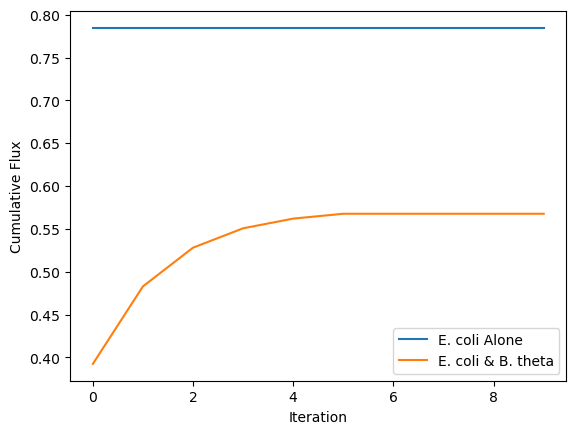

In [5]:
import matplotlib.pyplot as plt

ax = iifba.iifba_vis(F_single.loc[0,:][biomass_id], line_lab="E. coli Alone")
ax = iifba.iifba_vis(F_two.loc[0,:][biomass_id], ax=ax, line_lab="E. coli & B. theta")
plt.legend()


## Iter-Active Flux Sampling
This is more time-consuming due to multiple linear programs being solved... multiple times. See the [COBRApy Documentation](https://cobrapy.readthedocs.io/en/latest/sampling.html) for more details on flux sampling.

In [ ]:
from iifba import iisampling
import pickle

f, F_sampling, M = iisampling(models, media, rel_abund="equal", iters=10, flow=0.5, # default values
                              m_vals=[10, 10], objective_percent=0.9)

with open('ii_sampling_example.pkl', 'wb') as file:
	pickle.dump([f, F, M], file)



## Plot iiSampling

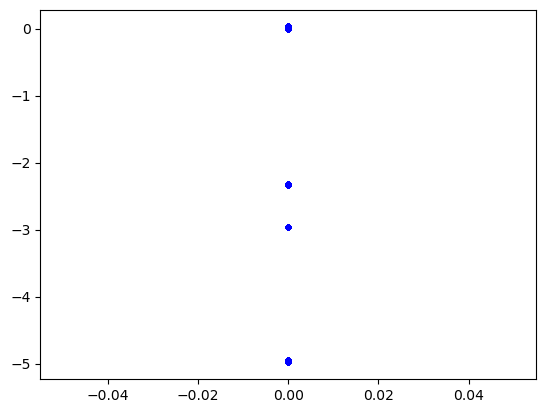

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open("../../Original/ii_sampling_061025.pkl", "rb") as file:
    f, F, M = pickle.load(file)


# Plot Sampling Results
org = 0
flux = 'EX_ac(e)'
#flux = 'EX_glc_D(e)'
#flux = 'biomass525'

# First iteration
for j in range(len(F[org][flux][i])):
    plt.plot(0,F[org][flux][0][j],'b.',alpha=0.1)

# N+1 iterations
for i in range(1,M.shape[1]+1):
    #dots for all flux values
    for j in range(len(F[org][flux][i])):
        plt.plot(i,F[org][flux][i][j],'b.',alpha=0.1)
    #lines linking flux values
    for j in range(len(F[org][flux][i])):
        m_ind = M[int(np.floor(j/M.shape[0]))][i-1]
        plt.plot([i-1,i],[F[org][flux][i-1][m_ind],F[org][flux][i][j]],'b-',alpha=0.05)

org = 1
flux = 'EX_ac(e)'
#flux = 'EX_glc_D(e)'
#flux = 'bio1'

# First iteration
for j in range(len(F[org][flux][i])):
    plt.plot(0,F[org][flux][0][j],'r.',alpha=0.1)

# N+1 iterations
for i in range(1,M.shape[1]+1):
    #dots for all flux values
    for j in range(len(F[org][flux][i])):
        plt.plot(i,F[org][flux][i][j],'r.',alpha=0.1)
    #lines linking flux values
    for j in range(len(F[org][flux][i])):
        m_ind = M[int(np.floor(j/M.shape[0]))][i-1]
        plt.plot([i-1,i],[F[org][flux][i-1][m_ind],F[org][flux][i][j]],'r-',alpha=0.05)   